In [1]:
#Import useful functions
import warnings
warnings.filterwarnings("ignore")
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm
from sklearn.utils.multiclass import unique_labels
import itertools
from scipy import misc
import math
import os
import glob
import xlrd
import xlwt
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from PIL import Image
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import pylab as plt
import numpy as np
from scipy.signal import argrelextrema
from IPython.display import Image
import matplotlib.patches as patches
import matplotlib as matplotlib
import xlsxwriter
from xlrd import open_workbook
from xlutils.copy import copy
from sklearn.model_selection import train_test_split
from datetime import datetime
plt.style.use('fivethirtyeight')
import itertools
from fbprophet import Prophet
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
import xlrd

In [2]:
#Function Saves Forecast Graphs to New Sheet in Excel File
from openpyxl import load_workbook
from openpyxl.drawing.image import Image
def graphforecast(filenamefinal, imdir):
    imdir1= imdir+'/{}'
    for im in os.listdir(imdir):
        imname = im.split('.')[0]
        workbook = load_workbook(filename=filenamefinal)
        sheet = workbook.create_sheet(imname)
        logo = Image(imdir1.format(im))
        loc ='A1'
        sheet.add_image(logo, loc)
        workbook.save(filenamefinal)
    return filenamefinal

In [3]:
#Select Arima Test Model Parameters
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

**Must Specify Foldername and Sheetname**

In [4]:
foldername = '/Users/JoyThompson/Desktop/Client Forecasting/LG/LG.xlsx'
sheetname='shipsales'

In [5]:
#Open Excel File and Read Sheet
monthlyrev=pd.read_excel(foldername, sheetname=sheetname)
#Create List of Dates
datesall=['2018-01-31','2018-02-28','2018-03-31','2018-04-30',
         '2018-05-31','2018-06-30','2018-07-31','2018-08-31','2018-09-30','2018-10-31','2018-11-30','2018-12-31','2019-01-31','2019-02-28','2019-03-31','2019-04-30',
         '2019-05-31','2019-06-30','2019-07-31','2019-08-31','2019-09-30','2019-10-31','2019-11-30','2019-12-31',
         '2020-01-31','2020-02-29','2020-03-31','2020-04-30','2020-05-31','2020-06-30','2020-07-31',
         '2020-08-31','2020-09-30','2020-10-31','2020-11-30','2020-12-31']
#Convert Dates to Datetime Format
datestopd=[]
for column in datesall:
        date=pd.to_datetime(column)
        datestopd.append(date)

**Must Select Appropriate Historical Data Input Dates**

In [6]:
datesinput=datestopd[0:22]

In [7]:
#Standardize Data and Format for Forecasting
revmatrix=monthlyrev.as_matrix(columns=['Shipped Product Sales'])
revtransformer = StandardScaler()
revtransformer.fit(revmatrix)
ystand = revtransformer.transform(revmatrix)
ylist=[]

countmonths=0
for ind in monthlyrev.index:
    rev=ystand[countmonths][0]
    ylist.append(float(rev))
    countmonths=countmonths+1
forecastin=pd.DataFrame({'ds': datesinput,'y':ylist})
forecastin=forecastin.set_index('ds')
print(forecastin)

                   y
ds                  
2018-01-31  1.698302
2018-02-28 -0.459586
2018-03-31  0.638916
2018-04-30  0.024322
2018-05-31 -1.031585
2018-06-30 -0.901027
2018-07-31 -0.763093
2018-08-31 -0.057335
2018-09-30 -1.240440
2018-10-31 -0.273198
2018-11-30  0.890023
2018-12-31  2.456023
2019-01-31 -0.710846
2019-02-28 -1.302133
2019-03-31  0.079606
2019-04-30 -1.093863
2019-05-31 -0.571414
2019-06-30 -0.743060
2019-07-31  0.373648
2019-08-31  0.797096
2019-09-30  0.828371
2019-10-31  1.361272


**Specify Number of Projection Months and Confidence Interval Width**

In [8]:
intwidth=.75
projectmonths=14

In [9]:
#Forecast Data
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
aicnum=[]
param1=[]
param2=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            results = sm.tsa.statespace.SARIMAX(forecastin,order=param,seasonal_order=param_seasonal, freq='M').fit()
            param1.append(param)
            param2.append(param_seasonal)
            aicnum.append(results.aic)
        except:
            continue
minpos = aicnum.index(min(aicnum)) 
ordervarrev=param1[minpos]
seasonalvarrev=param2[minpos]
   
resultsrev = sm.tsa.statespace.SARIMAX(forecastin, order=ordervarrev,seasonal_order=seasonalvarrev, freq='M').fit()
forecastdatarev=resultsrev.forecast(steps=14, freq='M')
forecastdatarevenue=forecastdatarev.reset_index()

In [10]:
#Unstandardize Forecast
forecastdatarev = revtransformer.inverse_transform(forecastdatarevenue[0])
ct=0
ylist=[]
yhighlist=[]
ylowlist=[]
datelist=[]
spendlist=[]
for datefor in forecastdatarevenue.index:
    date=forecastdatarevenue.loc[datefor, 'index']
    datelist.append(date)
    sales=forecastdatarev[ct]
    ylist.append(sales)
    salesl=sales*.9
    ylowlist.append(salesl)
    salesu=sales*1.1
    yhighlist.append(salesu)    
    ct=ct+1

**Forecast**

In [11]:
forecastout=pd.DataFrame({'Month': datelist, 'Revenue Forecast':ylist, 'Upper Bound Forecast':yhighlist,
                    'Lower Bound Forecast':ylowlist})
forecastout.set_index('Month')

,Revenue Forecast,Upper Bound Forecast,Lower Bound Forecast
Month,,,
2019-11-30,128716.999999,141588.699999,115845.299999
2019-12-31,147894.499999,162683.949999,133105.049999
2020-01-31,109112.499999,120023.749999,98201.249999
2020-02-29,101871.499999,112058.649999,91684.349999
2020-03-31,118792.499999,130671.749999,106913.249999
2020-04-30,104421.999999,114864.199999,93979.799999
2020-05-31,110819.999999,121901.999999,99737.999999
2020-06-30,108717.999999,119589.799999,97846.199999
2020-07-31,122393.389999,134632.728999,110154.050999


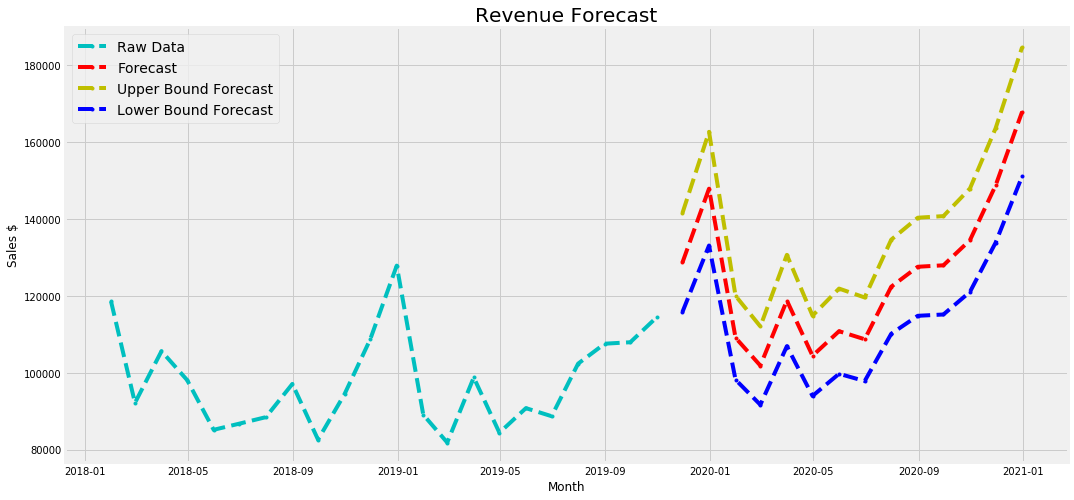

In [12]:
fig, axes = plt.subplots(1,1, figsize=(16,8));
plt.style.use('fivethirtyeight')
axes.plot_date(datesinput, monthlyrev['Shipped Product Sales'], '--.c');
axes.plot_date(datelist,ylist, '--.r');
axes.plot_date(datelist,yhighlist, '--.y');
axes.plot_date(datelist,ylowlist, '--.b');
axes.set_ylabel('Sales $');
axes.set_xlabel('Month');
axes.set_title('Revenue Forecast');
axes.legend(('Raw Data','Forecast', 'Upper Bound Forecast', 'Lower Bound Forecast'))

**Must Specify File Path to Save a Copy of Graph as Image and Ouput File Path**

In [13]:
figname='/Users/JoyThompson/Desktop/Client Forecasting/LG/graphs/LGrevforecast.png'
figpath='/Users/JoyThompson/Desktop/Client Forecasting/LG/graphs'
filenamefinal='/Users/JoyThompson/Desktop/Client Forecasting/LG/Forecast19.xlsx'

In [14]:
#Save Image and Graph to Excel File
fig.savefig(figname)
writer = pd.ExcelWriter(filenamefinal, engine='xlsxwriter')
forecastout.to_excel(writer, sheet_name='Sheet1')
writer.save()

**Output File Path**

In [15]:
graphforecast(filenamefinal, figpath)

'/Users/JoyThompson/Desktop/Client Forecasting/LG/Forecast19.xlsx'